# Load in model

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from baukit import TraceDict


# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Sparse AE's

In [2]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
num_layers = len(cache_names)
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

# Load training data

In [3]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# The batch size is for loading activations from the LLM, not for inference on the autoencoder
cfg = dotdict()
cfg.dataset_name="stas/openwebtext-10k"
cfg.max_length = 256
cfg.model_batch_size = 4
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")
num_features, d_model = autoencoder.encoder.shape

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11226112


## Model Definitions

In [4]:
from torch.optim import Adam
from torch import nn
class sparse_two_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x
    
class mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

    
class sparse_nonlinear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class linear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        return x

class linear_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, output_size, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return x

## Find Dead Features in Output layers

In [5]:

total_batches = 500
feature_activations = torch.zeros((num_layers, num_features))
norms = torch.zeros((num_layers))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)

        # Grab intermediate activations in ret
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
    
        for cache_name_ind in range(num_layers):
            #Only find dead features in output layer. This will effect MSE the most
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            output_activations = ret[output_cache_name].output
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            
            norms[cache_name_ind] += output_internal_activations.norm(dim=1).mean().cpu()
                

            #Now we have internal activations, run through autoencoder
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            
            feature_activations[cache_name_ind] += output_internal_activations.sum(dim=0).cpu()
        if i > total_batches:
            break
    alive_features_ind = (feature_activations != 0)
    alive_features_ind = alive_features_ind
    norms = norms/total_batches
normalization_per_layer = (norms/norms.min())**2
print(f"Norms: {norms}")
print(f"Alive features: {alive_features_ind.sum(dim=1)} / {num_features}")

  0%|          | 0/10963 [00:00<?, ?it/s]

  5%|▍         | 501/10963 [00:16<05:45, 30.26it/s]

Norms: tensor([ 4.2548,  6.8764,  9.6634, 13.1096, 54.0150])
Alive features: tensor([1084,  774, 1343, 1601,  841]) / 3072


In [24]:
initialize_weights = False
two_nonlinear_weights = []
mlp_weights = []
nonlinear_weights = []
linear_weights = []
mlp_weights_no_bias = []
nonlinear_weights_no_bias = []
linear_weights_no_bias = []

two_nonlinear_optimizers = []
mlp_optimizers = []
nonlinear_optimizers = []
linear_optimizers = []
mlp_optimizers_no_bias = []
nonlinear_optimizers_no_bias = []
linear_optimizers_no_bias = []
for auto_ind in range(len(autoencoders)//2):
    two_nonlinear_weights.append(sparse_two_nonlinear(num_features))
    two_nonlinear_weights[-1].to(device)
    two_nonlinear_optimizers.append(Adam(two_nonlinear_weights[-1].parameters(), lr=1e-3))

    mlp_weights.append(mlp(num_features))
    mlp_weights[-1].to(device)
    mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

    mlp_weights_no_bias.append(mlp_no_bias(num_features))
    mlp_weights_no_bias[-1].to(device)
    mlp_optimizers_no_bias.append(Adam(mlp_weights_no_bias[-1].parameters(), lr=1e-3))

    nonlinear_weights.append(sparse_nonlinear(num_features))
    nonlinear_weights[-1].to(device)
    nonlinear_optimizers.append(Adam(nonlinear_weights[-1].parameters(), lr=1e-3))

    nonlinear_weights_no_bias.append(sparse_nonlinear_no_bias(num_features))
    nonlinear_weights_no_bias[-1].to(device)
    nonlinear_optimizers_no_bias.append(Adam(nonlinear_weights_no_bias[-1].parameters(), lr=1e-3))

    linear_weights.append(linear(num_features))
    linear_weights[-1].to(device)
    linear_optimizers.append(Adam(linear_weights[-1].parameters(), lr=1e-3))

    linear_weights_no_bias.append(linear_no_bias(num_features))
    linear_weights_no_bias[-1].to(device)
    linear_optimizers_no_bias.append(Adam(linear_weights_no_bias[-1].parameters(), lr=1e-3))

    if(initialize_weights): #Note this doesn't work,
        # Multiply the decoder weights by mlp weights & second autoencoder's encoder weights
        decoder = autoencoders[auto_ind].encoder
        mlp_enc = model.gpt_neox.layers[auto_ind+1].mlp.dense_h_to_4h.weight.detach().T
        mlp_dec = model.gpt_neox.layers[auto_ind+1].mlp.dense_4h_to_h.weight.detach().T
        encoder = autoencoders[auto_ind+1].encoder.T
        initial_weights = decoder @ mlp_enc @ mlp_dec @ encoder
        nonlinear_weights[-1].linear.weight.data = initial_weights
        linear_weights[-1].linear.weight.data = initial_weights

## Train the model

In [25]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    l1_alpha = 1e-3
    batch_size = 32
    losses = [[] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            x_hat = sparse_weights[cache_name_ind](input_internal_activations)

            # loss = mse(x_hat, output_internal_activations)
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind.to(device))
            indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind.to(device))
            loss = mse(indexed_x_hat, indexed_output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())

            if i % 100 == 0:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
            
        if i > 2500:
            # Stop training after 1000 batches
            break
    return losses
# two_nonlinear_losses = train_sparse_model(model, dataset, device, two_nonlinear_weights, autoencoders, cache_names, two_nonlinear_optimizers)
# mlp_losses = train_sparse_model(model, dataset, device, mlp_weights, autoencoders, cache_names, mlp_optimizers)

# nonlinear_losses = train_sparse_model(model, dataset, device, nonlinear_weights, autoencoders, cache_names, nonlinear_optimizers)
# linear_losses = train_sparse_model(model, dataset, device, linear_weights, autoencoders, cache_names, linear_optimizers)

mlp_losses_no_bias = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)
# nonlinear_losses_no_bias = train_sparse_model(model, dataset, device, nonlinear_weights_no_bias, autoencoders, cache_names, nonlinear_optimizers_no_bias)
linear_losses_no_bias = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias)

  0%|          | 1/10963 [00:00<30:56,  5.91it/s]

Layers: 0 | MSE Loss: 0.004322286695241928 | L1 Loss: 27.718883514404297
Layers: 1 | MSE Loss: 0.06588244438171387 | L1 Loss: 27.715042114257812
Layers: 2 | MSE Loss: 0.022075379267334938 | L1 Loss: 27.718612670898438
Layers: 3 | MSE Loss: 0.05147479474544525 | L1 Loss: 27.71268081665039
Layers: 4 | MSE Loss: 3.201089859008789 | L1 Loss: 27.71269989013672


  1%|          | 101/10963 [00:16<30:33,  5.93it/s]

Layers: 0 | MSE Loss: 0.001530128880403936 | L1 Loss: 30.190353393554688
Layers: 1 | MSE Loss: 0.003530239686369896 | L1 Loss: 36.254371643066406
Layers: 2 | MSE Loss: 0.003809250658378005 | L1 Loss: 33.71506881713867
Layers: 3 | MSE Loss: 0.00539721455425024 | L1 Loss: 34.287803649902344
Layers: 4 | MSE Loss: 0.0883595272898674 | L1 Loss: 46.33799743652344


  2%|▏         | 201/10963 [00:33<29:48,  6.02it/s]

Layers: 0 | MSE Loss: 0.001315824338234961 | L1 Loss: 32.889827728271484
Layers: 1 | MSE Loss: 0.004636046011000872 | L1 Loss: 39.11187744140625
Layers: 2 | MSE Loss: 0.003735021920874715 | L1 Loss: 37.278480529785156
Layers: 3 | MSE Loss: 0.005470155272632837 | L1 Loss: 38.835540771484375
Layers: 4 | MSE Loss: 0.08340522646903992 | L1 Loss: 47.176841735839844


  3%|▎         | 301/10963 [00:49<29:36,  6.00it/s]

Layers: 0 | MSE Loss: 0.0010609881719574332 | L1 Loss: 34.78107833862305
Layers: 1 | MSE Loss: 0.003014154266566038 | L1 Loss: 41.508506774902344
Layers: 2 | MSE Loss: 0.0034353993833065033 | L1 Loss: 39.730018615722656
Layers: 3 | MSE Loss: 0.004211383406072855 | L1 Loss: 41.899688720703125
Layers: 4 | MSE Loss: 0.05672357976436615 | L1 Loss: 48.672969818115234


  4%|▎         | 401/10963 [01:06<29:19,  6.00it/s]

Layers: 0 | MSE Loss: 0.0009368319297209382 | L1 Loss: 36.366493225097656
Layers: 1 | MSE Loss: 0.002292020944878459 | L1 Loss: 43.44724655151367
Layers: 2 | MSE Loss: 0.002833839040249586 | L1 Loss: 41.8324089050293
Layers: 3 | MSE Loss: 0.003706634510308504 | L1 Loss: 44.2335205078125
Layers: 4 | MSE Loss: 0.052386097609996796 | L1 Loss: 50.532222747802734


  5%|▍         | 501/10963 [01:23<29:24,  5.93it/s]

Layers: 0 | MSE Loss: 0.0008811161387711763 | L1 Loss: 37.66905975341797
Layers: 1 | MSE Loss: 0.002843823516741395 | L1 Loss: 45.23296356201172
Layers: 2 | MSE Loss: 0.003028517123311758 | L1 Loss: 43.465145111083984
Layers: 3 | MSE Loss: 0.003573203692212701 | L1 Loss: 46.03047180175781
Layers: 4 | MSE Loss: 0.03903947398066521 | L1 Loss: 51.76481628417969


  5%|▌         | 601/10963 [01:39<29:00,  5.95it/s]

Layers: 0 | MSE Loss: 0.000726148602552712 | L1 Loss: 38.90370178222656
Layers: 1 | MSE Loss: 0.0021853812504559755 | L1 Loss: 46.73281478881836
Layers: 2 | MSE Loss: 0.0029978209640830755 | L1 Loss: 45.12905502319336
Layers: 3 | MSE Loss: 0.003681812435388565 | L1 Loss: 47.863739013671875
Layers: 4 | MSE Loss: 0.03989608958363533 | L1 Loss: 52.94298553466797


  6%|▋         | 701/10963 [01:56<28:45,  5.95it/s]

Layers: 0 | MSE Loss: 0.0009118613670580089 | L1 Loss: 39.968772888183594
Layers: 1 | MSE Loss: 0.0026036142371594906 | L1 Loss: 48.144866943359375
Layers: 2 | MSE Loss: 0.002721622819080949 | L1 Loss: 46.45208740234375
Layers: 3 | MSE Loss: 0.0033211628906428814 | L1 Loss: 49.09067916870117
Layers: 4 | MSE Loss: 0.0351082980632782 | L1 Loss: 54.268699645996094


  7%|▋         | 801/10963 [02:13<28:30,  5.94it/s]

Layers: 0 | MSE Loss: 0.0007862073252908885 | L1 Loss: 41.08766174316406
Layers: 1 | MSE Loss: 0.0030031015630811453 | L1 Loss: 49.581443786621094
Layers: 2 | MSE Loss: 0.0027271881699562073 | L1 Loss: 47.869834899902344
Layers: 3 | MSE Loss: 0.003057734342291951 | L1 Loss: 50.375823974609375
Layers: 4 | MSE Loss: 0.02999625727534294 | L1 Loss: 56.30339050292969


  8%|▊         | 901/10963 [02:30<28:23,  5.91it/s]

Layers: 0 | MSE Loss: 0.0007396300788968801 | L1 Loss: 41.99871826171875
Layers: 1 | MSE Loss: 0.0023423274978995323 | L1 Loss: 51.104713439941406
Layers: 2 | MSE Loss: 0.0028855744749307632 | L1 Loss: 52.19560241699219
Layers: 3 | MSE Loss: 0.0031568531412631273 | L1 Loss: 51.60662078857422
Layers: 4 | MSE Loss: 0.03191295638680458 | L1 Loss: 57.66669464111328


  9%|▉         | 1001/10963 [02:47<28:02,  5.92it/s]

Layers: 0 | MSE Loss: 0.0008036934887059033 | L1 Loss: 42.8872184753418
Layers: 1 | MSE Loss: 0.00253471196629107 | L1 Loss: 52.48351287841797
Layers: 2 | MSE Loss: 0.002838711952790618 | L1 Loss: 52.614784240722656
Layers: 3 | MSE Loss: 0.0029124876018613577 | L1 Loss: 52.47711181640625
Layers: 4 | MSE Loss: 0.03127548098564148 | L1 Loss: 58.754173278808594


 10%|█         | 1101/10963 [03:04<27:57,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007204421563073993 | L1 Loss: 43.744117736816406
Layers: 1 | MSE Loss: 0.002311642048880458 | L1 Loss: 53.534751892089844
Layers: 2 | MSE Loss: 0.002614607335999608 | L1 Loss: 53.18980026245117
Layers: 3 | MSE Loss: 0.0028926392551511526 | L1 Loss: 53.28031539916992
Layers: 4 | MSE Loss: 0.03056439757347107 | L1 Loss: 59.89780807495117


 11%|█         | 1201/10963 [03:21<27:36,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007619346724823117 | L1 Loss: 44.50942611694336
Layers: 1 | MSE Loss: 0.0017863884568214417 | L1 Loss: 54.63669967651367
Layers: 2 | MSE Loss: 0.002507526660338044 | L1 Loss: 53.75284957885742
Layers: 3 | MSE Loss: 0.002903626998886466 | L1 Loss: 54.1236572265625
Layers: 4 | MSE Loss: 0.027472108602523804 | L1 Loss: 60.98745346069336


 12%|█▏        | 1301/10963 [03:38<27:21,  5.89it/s]

Layers: 0 | MSE Loss: 0.0006568634998984635 | L1 Loss: 45.25419235229492
Layers: 1 | MSE Loss: 0.0026652850210666656 | L1 Loss: 55.758567810058594
Layers: 2 | MSE Loss: 0.002732845488935709 | L1 Loss: 54.355064392089844
Layers: 3 | MSE Loss: 0.0030721621587872505 | L1 Loss: 54.90411376953125
Layers: 4 | MSE Loss: 0.030950583517551422 | L1 Loss: 62.05352783203125


 13%|█▎        | 1401/10963 [03:55<27:05,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007000675541348755 | L1 Loss: 45.97467041015625
Layers: 1 | MSE Loss: 0.0019820353481918573 | L1 Loss: 56.831939697265625
Layers: 2 | MSE Loss: 0.0024472493678331375 | L1 Loss: 55.02775192260742
Layers: 3 | MSE Loss: 0.0030720853246748447 | L1 Loss: 55.624290466308594
Layers: 4 | MSE Loss: 0.031057165935635567 | L1 Loss: 63.090354919433594


 14%|█▎        | 1501/10963 [04:12<27:06,  5.82it/s]

Layers: 0 | MSE Loss: 0.0007368873339146376 | L1 Loss: 46.654296875
Layers: 1 | MSE Loss: 0.00252886232919991 | L1 Loss: 57.75394821166992
Layers: 2 | MSE Loss: 0.002559806453064084 | L1 Loss: 55.63630294799805
Layers: 3 | MSE Loss: 0.003017958253622055 | L1 Loss: 56.28803634643555
Layers: 4 | MSE Loss: 0.03030078485608101 | L1 Loss: 64.14588928222656


 15%|█▍        | 1601/10963 [04:29<26:30,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007222446729429066 | L1 Loss: 47.302337646484375
Layers: 1 | MSE Loss: 0.0032282532192766666 | L1 Loss: 58.78754806518555
Layers: 2 | MSE Loss: 0.003781578503549099 | L1 Loss: 63.175506591796875
Layers: 3 | MSE Loss: 0.002963688923045993 | L1 Loss: 56.99794006347656
Layers: 4 | MSE Loss: 0.031373247504234314 | L1 Loss: 65.21363830566406


 16%|█▌        | 1701/10963 [04:46<26:17,  5.87it/s]

Layers: 0 | MSE Loss: 0.0007475966704078019 | L1 Loss: 48.00653839111328
Layers: 1 | MSE Loss: 0.002813065657392144 | L1 Loss: 59.54763412475586
Layers: 2 | MSE Loss: 0.002847078023478389 | L1 Loss: 63.943817138671875
Layers: 3 | MSE Loss: 0.0028586634434759617 | L1 Loss: 57.696136474609375
Layers: 4 | MSE Loss: 0.02959391474723816 | L1 Loss: 66.13818359375


 16%|█▋        | 1801/10963 [05:03<25:58,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007413857383653522 | L1 Loss: 48.68940353393555
Layers: 1 | MSE Loss: 0.0027581932954490185 | L1 Loss: 60.7631950378418
Layers: 2 | MSE Loss: 0.0027861648704856634 | L1 Loss: 64.06149291992188
Layers: 3 | MSE Loss: 0.0030004791915416718 | L1 Loss: 58.35844039916992
Layers: 4 | MSE Loss: 0.02891622856259346 | L1 Loss: 67.3218994140625


 17%|█▋        | 1901/10963 [05:20<25:41,  5.88it/s]

Layers: 0 | MSE Loss: 0.0006777931121177971 | L1 Loss: 49.34309005737305
Layers: 1 | MSE Loss: 0.0022029350511729717 | L1 Loss: 61.78229904174805
Layers: 2 | MSE Loss: 0.0038932061288505793 | L1 Loss: 64.35417938232422
Layers: 3 | MSE Loss: 0.0027904994785785675 | L1 Loss: 58.99168014526367
Layers: 4 | MSE Loss: 0.02782583236694336 | L1 Loss: 68.72807312011719


 18%|█▊        | 2001/10963 [05:37<25:29,  5.86it/s]

Layers: 0 | MSE Loss: 0.0006630001007579267 | L1 Loss: 49.971710205078125
Layers: 1 | MSE Loss: 0.0019312326330691576 | L1 Loss: 62.6414794921875
Layers: 2 | MSE Loss: 0.002475925488397479 | L1 Loss: 65.31713104248047
Layers: 3 | MSE Loss: 0.0025559188798069954 | L1 Loss: 59.63090515136719
Layers: 4 | MSE Loss: 0.02428300864994526 | L1 Loss: 69.56554412841797


 19%|█▉        | 2101/10963 [05:54<25:04,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007676267414353788 | L1 Loss: 50.56421661376953
Layers: 1 | MSE Loss: 0.0019990052096545696 | L1 Loss: 63.4630126953125
Layers: 2 | MSE Loss: 0.002867432776838541 | L1 Loss: 65.66717529296875
Layers: 3 | MSE Loss: 0.003257367294281721 | L1 Loss: 60.42576217651367
Layers: 4 | MSE Loss: 0.031499188393354416 | L1 Loss: 70.7472915649414


 20%|██        | 2201/10963 [06:11<24:53,  5.87it/s]

Layers: 0 | MSE Loss: 0.000708183622919023 | L1 Loss: 51.15001678466797
Layers: 1 | MSE Loss: 0.0016227434389293194 | L1 Loss: 64.06785583496094
Layers: 2 | MSE Loss: 0.002474199514836073 | L1 Loss: 65.92796325683594
Layers: 3 | MSE Loss: 0.0026221508160233498 | L1 Loss: 60.867034912109375
Layers: 4 | MSE Loss: 0.02463032491505146 | L1 Loss: 71.582275390625


 21%|██        | 2301/10963 [06:28<24:39,  5.85it/s]

Layers: 0 | MSE Loss: 0.0006332387565635145 | L1 Loss: 51.71464157104492
Layers: 1 | MSE Loss: 0.0024853739887475967 | L1 Loss: 64.85089111328125
Layers: 2 | MSE Loss: 0.002594372257590294 | L1 Loss: 66.07183837890625
Layers: 3 | MSE Loss: 0.002624604618176818 | L1 Loss: 61.37103271484375
Layers: 4 | MSE Loss: 0.025213442742824554 | L1 Loss: 72.32904052734375


 22%|██▏       | 2401/10963 [06:45<24:21,  5.86it/s]

Layers: 0 | MSE Loss: 0.0006358551909215748 | L1 Loss: 52.301414489746094
Layers: 1 | MSE Loss: 0.002067635068669915 | L1 Loss: 65.66680145263672
Layers: 2 | MSE Loss: 0.0024067116901278496 | L1 Loss: 66.28862762451172
Layers: 3 | MSE Loss: 0.0028191411402076483 | L1 Loss: 61.898048400878906
Layers: 4 | MSE Loss: 0.027421440929174423 | L1 Loss: 73.32064056396484


 23%|██▎       | 2501/10963 [07:02<23:59,  5.88it/s]

Layers: 0 | MSE Loss: 0.0006503556505776942 | L1 Loss: 52.79283905029297
Layers: 1 | MSE Loss: 0.0023083018604665995 | L1 Loss: 66.404541015625
Layers: 2 | MSE Loss: 0.0027445403393357992 | L1 Loss: 66.51676177978516
Layers: 3 | MSE Loss: 0.0029040451627224684 | L1 Loss: 62.324371337890625
Layers: 4 | MSE Loss: 0.02890601195394993 | L1 Loss: 74.09883117675781


  0%|          | 2/10963 [00:00<17:19, 10.55it/s]

Layers: 0 | MSE Loss: 0.006197882350534201 | L1 Loss: 27.716259002685547
Layers: 1 | MSE Loss: 0.06209835782647133 | L1 Loss: 27.71056365966797
Layers: 2 | MSE Loss: 0.035069067031145096 | L1 Loss: 27.722007751464844
Layers: 3 | MSE Loss: 0.06862900406122208 | L1 Loss: 27.722150802612305
Layers: 4 | MSE Loss: 3.4153754711151123 | L1 Loss: 27.71503257751465


  1%|          | 102/10963 [00:09<16:55, 10.69it/s]

Layers: 0 | MSE Loss: 0.0032222967129200697 | L1 Loss: 20.835996627807617
Layers: 1 | MSE Loss: 0.05699635297060013 | L1 Loss: 23.198837280273438
Layers: 2 | MSE Loss: 0.010851512663066387 | L1 Loss: 21.55891990661621
Layers: 3 | MSE Loss: 0.02198578603565693 | L1 Loss: 22.416210174560547
Layers: 4 | MSE Loss: 2.880399465560913 | L1 Loss: 23.73065948486328


  2%|▏         | 202/10963 [00:18<16:44, 10.71it/s]

Layers: 0 | MSE Loss: 0.0029183104634284973 | L1 Loss: 20.586227416992188
Layers: 1 | MSE Loss: 0.042939651757478714 | L1 Loss: 23.49810791015625
Layers: 2 | MSE Loss: 0.008294551633298397 | L1 Loss: 21.74725914001465
Layers: 3 | MSE Loss: 0.014438965357840061 | L1 Loss: 22.4043025970459
Layers: 4 | MSE Loss: 2.7069544792175293 | L1 Loss: 23.775861740112305


  3%|▎         | 302/10963 [00:28<16:37, 10.69it/s]

Layers: 0 | MSE Loss: 0.00264145084656775 | L1 Loss: 20.595417022705078
Layers: 1 | MSE Loss: 0.0388597697019577 | L1 Loss: 23.638715744018555
Layers: 2 | MSE Loss: 0.007082748226821423 | L1 Loss: 21.75104331970215
Layers: 3 | MSE Loss: 0.01117569301277399 | L1 Loss: 22.424346923828125
Layers: 4 | MSE Loss: 2.2722387313842773 | L1 Loss: 23.92749786376953


  4%|▎         | 402/10963 [00:37<16:23, 10.74it/s]

Layers: 0 | MSE Loss: 0.0024011454079300165 | L1 Loss: 20.62349510192871
Layers: 1 | MSE Loss: 0.038605544716119766 | L1 Loss: 23.671524047851562
Layers: 2 | MSE Loss: 0.005993558559566736 | L1 Loss: 21.713239669799805
Layers: 3 | MSE Loss: 0.009886881336569786 | L1 Loss: 22.458786010742188
Layers: 4 | MSE Loss: 2.427583932876587 | L1 Loss: 24.182369232177734


  5%|▍         | 502/10963 [00:46<16:14, 10.73it/s]

Layers: 0 | MSE Loss: 0.0020966604351997375 | L1 Loss: 20.62024688720703
Layers: 1 | MSE Loss: 0.027397945523262024 | L1 Loss: 23.648208618164062
Layers: 2 | MSE Loss: 0.005522470921278 | L1 Loss: 21.643728256225586
Layers: 3 | MSE Loss: 0.007708405144512653 | L1 Loss: 22.466922760009766
Layers: 4 | MSE Loss: 2.148087501525879 | L1 Loss: 24.155485153198242


  5%|▌         | 602/10963 [00:56<16:09, 10.69it/s]

Layers: 0 | MSE Loss: 0.0023803445510566235 | L1 Loss: 20.583940505981445
Layers: 1 | MSE Loss: 0.028446674346923828 | L1 Loss: 23.6120662689209
Layers: 2 | MSE Loss: 0.004467294551432133 | L1 Loss: 21.474889755249023
Layers: 3 | MSE Loss: 0.007455842103809118 | L1 Loss: 22.38379669189453
Layers: 4 | MSE Loss: 2.2385318279266357 | L1 Loss: 24.117752075195312


  6%|▋         | 702/10963 [01:05<15:55, 10.74it/s]

Layers: 0 | MSE Loss: 0.002327151596546173 | L1 Loss: 20.586387634277344
Layers: 1 | MSE Loss: 0.02484470047056675 | L1 Loss: 23.59914207458496
Layers: 2 | MSE Loss: 0.00472397543489933 | L1 Loss: 21.427724838256836
Layers: 3 | MSE Loss: 0.007119183894246817 | L1 Loss: 22.414199829101562
Layers: 4 | MSE Loss: 1.9798364639282227 | L1 Loss: 24.2963924407959


  7%|▋         | 802/10963 [01:14<15:46, 10.73it/s]

Layers: 0 | MSE Loss: 0.0019611527677625418 | L1 Loss: 20.577552795410156
Layers: 1 | MSE Loss: 0.0200510136783123 | L1 Loss: 23.539920806884766
Layers: 2 | MSE Loss: 0.004025300964713097 | L1 Loss: 21.366588592529297
Layers: 3 | MSE Loss: 0.006083150859922171 | L1 Loss: 22.377166748046875
Layers: 4 | MSE Loss: 1.5981961488723755 | L1 Loss: 24.484416961669922


  8%|▊         | 902/10963 [01:24<15:34, 10.76it/s]

Layers: 0 | MSE Loss: 0.0021242445800453424 | L1 Loss: 20.682147979736328
Layers: 1 | MSE Loss: 0.02016294002532959 | L1 Loss: 23.575237274169922
Layers: 2 | MSE Loss: 0.0039041496347635984 | L1 Loss: 21.517248153686523
Layers: 3 | MSE Loss: 0.00686677685007453 | L1 Loss: 22.466339111328125
Layers: 4 | MSE Loss: 1.542468786239624 | L1 Loss: 24.799673080444336


  9%|▉         | 1002/10963 [01:33<15:32, 10.68it/s]

Layers: 0 | MSE Loss: 0.001948727061972022 | L1 Loss: 20.697355270385742
Layers: 1 | MSE Loss: 0.017856892198324203 | L1 Loss: 23.533737182617188
Layers: 2 | MSE Loss: 0.004276590887457132 | L1 Loss: 21.302448272705078
Layers: 3 | MSE Loss: 0.006054477766156197 | L1 Loss: 22.378780364990234
Layers: 4 | MSE Loss: 1.3990004062652588 | L1 Loss: 24.587133407592773


 10%|█         | 1102/10963 [01:42<15:19, 10.72it/s]

Layers: 0 | MSE Loss: 0.0019877864979207516 | L1 Loss: 20.63495635986328
Layers: 1 | MSE Loss: 0.01431285496801138 | L1 Loss: 23.469451904296875
Layers: 2 | MSE Loss: 0.004023540299385786 | L1 Loss: 21.190013885498047
Layers: 3 | MSE Loss: 0.005268503911793232 | L1 Loss: 22.31470489501953
Layers: 4 | MSE Loss: 1.1307954788208008 | L1 Loss: 24.324016571044922


 11%|█         | 1202/10963 [01:52<15:09, 10.73it/s]

Layers: 0 | MSE Loss: 0.0019159381045028567 | L1 Loss: 20.609203338623047
Layers: 1 | MSE Loss: 0.01411418616771698 | L1 Loss: 23.470205307006836
Layers: 2 | MSE Loss: 0.0038928308058530092 | L1 Loss: 21.11998176574707
Layers: 3 | MSE Loss: 0.005224041640758514 | L1 Loss: 22.26289939880371
Layers: 4 | MSE Loss: 1.1720051765441895 | L1 Loss: 24.24190330505371


 12%|█▏        | 1302/10963 [02:01<14:59, 10.75it/s]

Layers: 0 | MSE Loss: 0.001883861725218594 | L1 Loss: 20.73200035095215
Layers: 1 | MSE Loss: 0.012019269168376923 | L1 Loss: 23.739582061767578
Layers: 2 | MSE Loss: 0.004086262546479702 | L1 Loss: 21.822433471679688
Layers: 3 | MSE Loss: 0.005083929281681776 | L1 Loss: 22.552276611328125
Layers: 4 | MSE Loss: 1.018935203552246 | L1 Loss: 24.952892303466797


 13%|█▎        | 1402/10963 [02:10<14:54, 10.69it/s]

Layers: 0 | MSE Loss: 0.002123510465025902 | L1 Loss: 20.795568466186523
Layers: 1 | MSE Loss: 0.01092788390815258 | L1 Loss: 23.679458618164062
Layers: 2 | MSE Loss: 0.0036911910865455866 | L1 Loss: 21.527481079101562
Layers: 3 | MSE Loss: 0.00495628546923399 | L1 Loss: 22.467082977294922
Layers: 4 | MSE Loss: 1.115410327911377 | L1 Loss: 24.707073211669922


 14%|█▎        | 1502/10963 [02:20<14:43, 10.71it/s]

Layers: 0 | MSE Loss: 0.0016223288839682937 | L1 Loss: 20.7095947265625
Layers: 1 | MSE Loss: 0.014104383066296577 | L1 Loss: 23.610464096069336
Layers: 2 | MSE Loss: 0.003822969039902091 | L1 Loss: 21.319046020507812
Layers: 3 | MSE Loss: 0.005586945917457342 | L1 Loss: 22.30874252319336
Layers: 4 | MSE Loss: 0.9381945729255676 | L1 Loss: 24.59811019897461


 15%|█▍        | 1602/10963 [02:29<14:37, 10.67it/s]

Layers: 0 | MSE Loss: 0.001772983931005001 | L1 Loss: 20.649234771728516
Layers: 1 | MSE Loss: 0.012064442969858646 | L1 Loss: 23.4908504486084
Layers: 2 | MSE Loss: 0.0037055134307593107 | L1 Loss: 21.136510848999023
Layers: 3 | MSE Loss: 0.004940559156239033 | L1 Loss: 22.18006134033203
Layers: 4 | MSE Loss: 0.7363891005516052 | L1 Loss: 24.30946922302246


 16%|█▌        | 1702/10963 [02:38<14:23, 10.72it/s]

Layers: 0 | MSE Loss: 0.0019535382743924856 | L1 Loss: 20.642780303955078
Layers: 1 | MSE Loss: 0.01003483310341835 | L1 Loss: 23.463062286376953
Layers: 2 | MSE Loss: 0.0034531294368207455 | L1 Loss: 21.100624084472656
Layers: 3 | MSE Loss: 0.004915238358080387 | L1 Loss: 22.110883712768555
Layers: 4 | MSE Loss: 0.8203305006027222 | L1 Loss: 24.35085678100586


 16%|█▋        | 1802/10963 [02:48<14:15, 10.71it/s]

Layers: 0 | MSE Loss: 0.0017254550475627184 | L1 Loss: 20.694931030273438
Layers: 1 | MSE Loss: 0.009223761036992073 | L1 Loss: 24.08221435546875
Layers: 2 | MSE Loss: 0.003747732611373067 | L1 Loss: 23.17578125
Layers: 3 | MSE Loss: 0.005036856047809124 | L1 Loss: 22.416881561279297
Layers: 4 | MSE Loss: 0.7508428692817688 | L1 Loss: 24.783443450927734


 17%|█▋        | 1902/10963 [02:57<14:07, 10.69it/s]

Layers: 0 | MSE Loss: 0.0017849249998107553 | L1 Loss: 20.722667694091797
Layers: 1 | MSE Loss: 0.008422890678048134 | L1 Loss: 23.685871124267578
Layers: 2 | MSE Loss: 0.003945210482925177 | L1 Loss: 22.395275115966797
Layers: 3 | MSE Loss: 0.005533421877771616 | L1 Loss: 22.29861068725586
Layers: 4 | MSE Loss: 0.7645869851112366 | L1 Loss: 24.627819061279297


 18%|█▊        | 2002/10963 [03:06<13:56, 10.72it/s]

Layers: 0 | MSE Loss: 0.001778123783878982 | L1 Loss: 20.850990295410156
Layers: 1 | MSE Loss: 0.008954448625445366 | L1 Loss: 23.606975555419922
Layers: 2 | MSE Loss: 0.0036904155276715755 | L1 Loss: 21.98091697692871
Layers: 3 | MSE Loss: 0.004877299536019564 | L1 Loss: 22.22762680053711
Layers: 4 | MSE Loss: 0.7243030071258545 | L1 Loss: 24.560834884643555


 19%|█▉        | 2102/10963 [03:16<13:47, 10.71it/s]

Layers: 0 | MSE Loss: 0.0018654509913176298 | L1 Loss: 20.80929183959961
Layers: 1 | MSE Loss: 0.006485720630735159 | L1 Loss: 23.587337493896484
Layers: 2 | MSE Loss: 0.0036939173005521297 | L1 Loss: 21.70526123046875
Layers: 3 | MSE Loss: 0.004741715267300606 | L1 Loss: 22.3962459564209
Layers: 4 | MSE Loss: 0.5556023716926575 | L1 Loss: 24.594945907592773


 20%|██        | 2202/10963 [03:25<13:35, 10.75it/s]

Layers: 0 | MSE Loss: 0.0015607771929353476 | L1 Loss: 20.715560913085938
Layers: 1 | MSE Loss: 0.008261024951934814 | L1 Loss: 23.527137756347656
Layers: 2 | MSE Loss: 0.0034862332977354527 | L1 Loss: 21.418615341186523
Layers: 3 | MSE Loss: 0.00452872458845377 | L1 Loss: 22.262874603271484
Layers: 4 | MSE Loss: 0.4812701642513275 | L1 Loss: 24.483932495117188


 21%|██        | 2302/10963 [03:34<13:28, 10.71it/s]

Layers: 0 | MSE Loss: 0.0019254465587437153 | L1 Loss: 20.72562026977539
Layers: 1 | MSE Loss: 0.007810609880834818 | L1 Loss: 24.160259246826172
Layers: 2 | MSE Loss: 0.00377852120436728 | L1 Loss: 21.983686447143555
Layers: 3 | MSE Loss: 0.005293737631291151 | L1 Loss: 22.477245330810547
Layers: 4 | MSE Loss: 0.6648272275924683 | L1 Loss: 24.882116317749023


 22%|██▏       | 2402/10963 [03:44<13:18, 10.72it/s]

Layers: 0 | MSE Loss: 0.0016078007174655795 | L1 Loss: 20.62188720703125
Layers: 1 | MSE Loss: 0.007896272465586662 | L1 Loss: 23.784053802490234
Layers: 2 | MSE Loss: 0.003558371216058731 | L1 Loss: 21.57289695739746
Layers: 3 | MSE Loss: 0.00415137829259038 | L1 Loss: 22.253047943115234
Layers: 4 | MSE Loss: 0.45128026604652405 | L1 Loss: 24.707550048828125


 23%|██▎       | 2501/10963 [03:53<13:09, 10.71it/s]

Layers: 0 | MSE Loss: 0.001575996051542461 | L1 Loss: 20.68771743774414
Layers: 1 | MSE Loss: 0.007780969142913818 | L1 Loss: 23.639623641967773
Layers: 2 | MSE Loss: 0.003556485055014491 | L1 Loss: 21.39479637145996
Layers: 3 | MSE Loss: 0.004370429553091526 | L1 Loss: 22.299978256225586
Layers: 4 | MSE Loss: 0.4600355327129364 | L1 Loss: 24.788562774658203


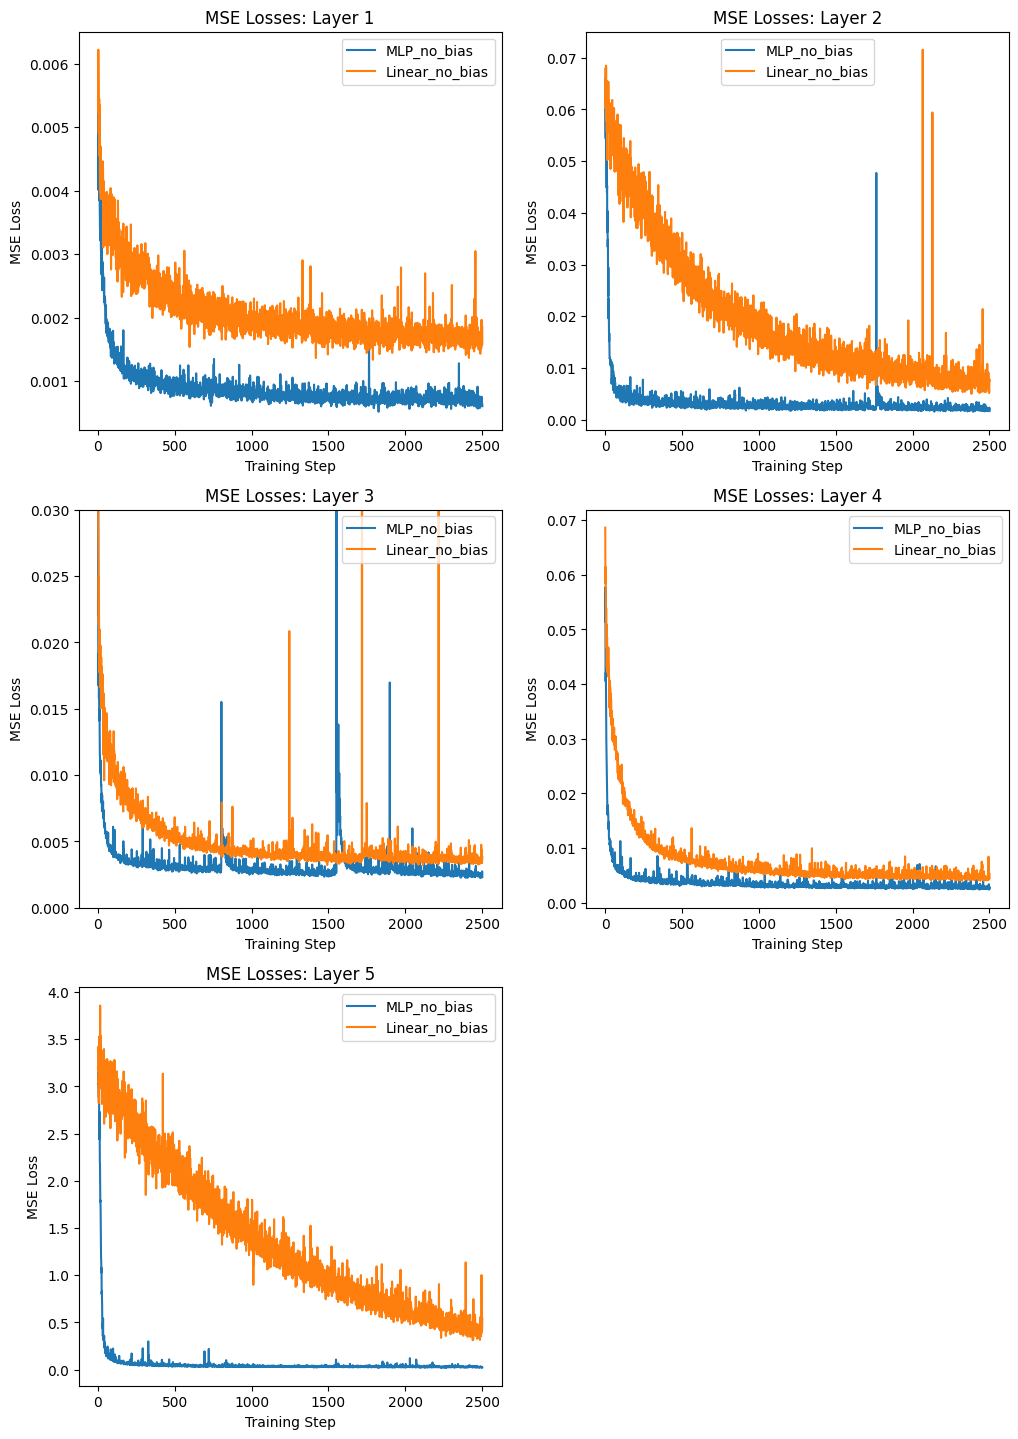

In [30]:
# Plot both losses
import matplotlib.pyplot as plt

num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # make a new plot
    # plt.figure()
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"MSE Losses: Layer {layer+1}")
    # plt.plot(two_nonlinear_losses[layer])
    # plt.plot(mlp_losses[layer])
    plt.plot(mlp_losses_no_bias[layer])
    # plt.plot(nonlinear_losses[layer])
    # plt.plot(nonlinear_losses_no_bias[layer])
    # plt.plot(linear_losses[layer])
    plt.plot(linear_losses_no_bias[layer])
    if(layer ==2):
        # set max y to 0.05
        plt.ylim(0, 0.03)
    # plt.legend(["Two Nonlinear", "MLP", "MLP_no_bias", "Nonlinear", "Nonlinear_no_bias", "Linear", "Linear_no_bias"])
    # plt.legend(["Two Nonlinear", "MLP", "Nonlinear", "Linear"])
    plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    plt.ylabel("MSE Loss")
plt.show()

## Plot Feature-level losses

In [12]:
# Get the losses for each feature
mse = nn.MSELoss(reduction="none")
l1_alpha = 1e-3
batch_size = 32

# with dataset.formatted_as("pt"):
#     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
max_batches = 100
num_alive_features = alive_features_ind.sum(dim=1).cpu()
loss_diff = [torch.zeros(num_alive_feat) for num_alive_feat in num_alive_features]
# loss_diff = torch.zeros((len(cache_names)//2, 1024))
norms = np.zeros(len(cache_names)//2)
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            if(i == 0):
                # Print the norms of both input & output
                print(f"Layer: {cache_name_ind+1}")
                print(f"Input Norms: {input_internal_activations.norm(dim=1).mean()}")
                print(f"Output Norms: {output_internal_activations.norm(dim=1).mean()}")
                norms[cache_name_ind] = output_internal_activations.norm(dim=1).mean().cpu()
                
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            if(i == 0):
                # Also check dead features
                print(f"Input Dead Features: {(input_internal_activations.count_nonzero(dim=0) == 0).sum()}")
                print(f"Output Dead Features: {(output_internal_activations.count_nonzero(dim=0) == 0).sum()}")

            # Run features through mlp & linear
            x_hat_mlp = mlp_weights_no_bias[cache_name_ind](input_internal_activations)
            x_hat_linear = linear_weights_no_bias[cache_name_ind](input_internal_activations)
            
            # Get ind of alive features
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
            index_x_hat_mlp = x_hat_mlp.index_select(dim=1, index=current_alive_features_ind)
            index_x_hat_linear = x_hat_linear.index_select(dim=1, index=current_alive_features_ind)
            index_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)

            # We want to compare the MLP loss & linear loss
            # for every feature, so we mean the batch & pos, but not the feature
            mlp_loss = mse(index_x_hat_mlp, index_output_internal_activations).mean(dim=0).cpu()
            linear_loss = mse(index_x_hat_linear, index_output_internal_activations).mean(dim=0).cpu()

            # instead of mse, do cosine sim
            # mlp_loss = torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).cpu()
            # linear_loss = torch.cosine_similarity(x_hat_linear, output_internal_activations, dim=1).cpu()
            loss_diff[cache_name_ind] += linear_loss - mlp_loss
        if(i >= max_batches):
            break
loss_diff =  [loss_d / max_batches for loss_d in loss_diff]

  0%|          | 0/10963 [00:00<?, ?it/s]

Layer: 1
Input Norms: 7.127835273742676
Output Norms: 4.2564544677734375
Input Dead Features: 2087
Output Dead Features: 2360


TypeError: 'list' object is not callable

layer 0: 0.790
layer 1: 0.966
layer 2: 0.978
layer 3: 0.981
layer 4: 0.990


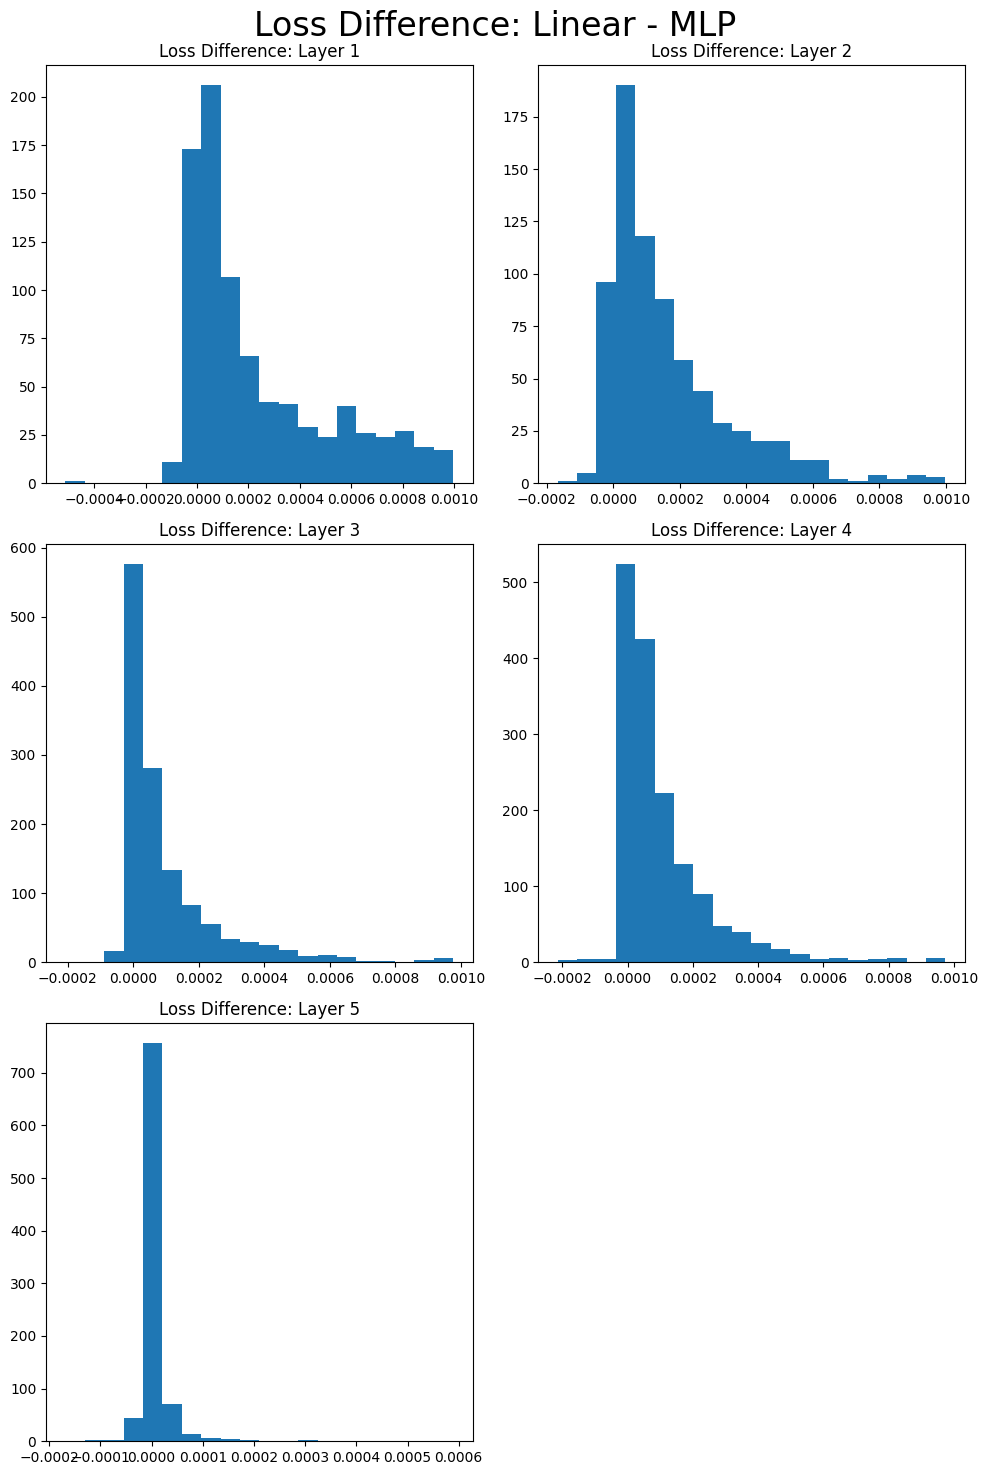

In [27]:
import matplotlib.pyplot as plt
normalization_per_layer = (norms/norms.min())**2

outlier_thresh =  10.0
num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    # filtered = loss_d[~is_outlier(loss_d, outlier_thresh)]
    threshold = 0.001
    filtered = loss_d[loss_d < threshold]
    percent_below_threshold = loss_d[loss_d < threshold].shape[0] / loss_d.shape[0]
    print(f"layer {layer}: {percent_below_threshold:.3f}")
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.hist(filtered, bins = 20)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
plt.suptitle("Loss Difference: Linear - MLP", fontsize=24)
plt.tight_layout()
plt.show()

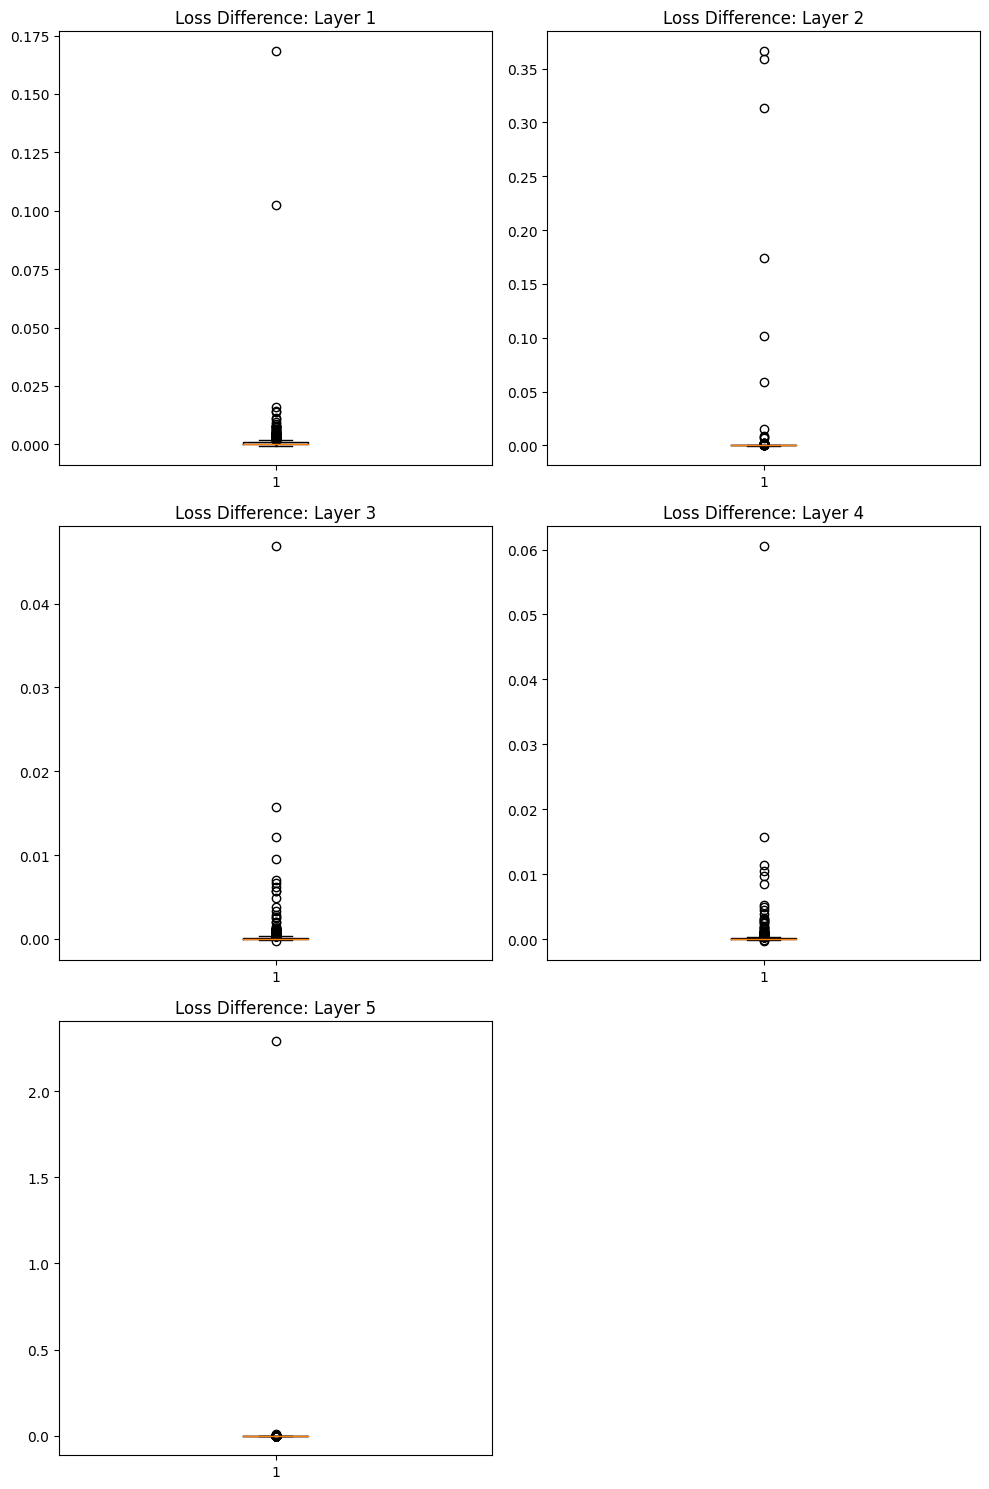

In [28]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()/ normalization_per_layer[layer]
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.boxplot(loss_d)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()

# Find linearly computed features & MLP ones

In [29]:
linear_features = []
mlp_features = []
threshold = 0.001
for layer in range(num_layers):
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    linear_ind = loss_d <= threshold
    linear_features.append(linear_ind)
    
    mlp_ind = loss_d > threshold
    mlp_features.append(mlp_ind)
# Save the features to file
import pickle
with open("linear_features.pkl", "wb") as f:
    pickle.dump(linear_features, f)
with open("mlp_features.pkl", "wb") as f:
    pickle.dump(mlp_features, f)
# Also save alive features
with open("alive_features.pkl", "wb") as f:
    pickle.dump(alive_features_ind, f)

In [6]:
# Load in the features
import pickle
with open("linear_features.pkl", "rb") as f:
    linear_features = pickle.load(f)
with open("mlp_features.pkl", "rb") as f:
    mlp_features = pickle.load(f)
with open("alive_features.pkl", "rb") as f:
    alive_features_ind = pickle.load(f)

## Pareto frontier of l1 alpha for linear layer (no bias), then MLP (no bias)

In [7]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 8
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [26]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, l1_alphas, feature_ind, max_batches = 500):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
                sparse_weight = sparse_weights[cache_name_ind][l1_alpha_ind].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                indexed_x_hat = x_hat
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=alive_and_selected_features)
                
                # Divide MSE_loss by normalization factor
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                # check if sparse_weight.linear2 exists
                if hasattr(sparse_weight, "linear2"):
                    l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                    l1_loss /= 2
                unweighted_loss = mse_loss + l1_loss
                loss = mse_loss + l1_alpha * l1_loss

                loss.backward()
                optimizers[cache_name_ind][l1_alpha_ind].step()
                optimizers[cache_name_ind][l1_alpha_ind].zero_grad()
                losses[cache_name_ind][l1_alpha_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][l1_alpha_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][l1_alpha_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > max_batches:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1
# l1_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 100]
l1_alphas = [1e-7, 1e-5, 1e-3, .1, 10, 100]
# l1_alphas = [1e-4, 0.01, .1, 1, 10]

mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas, linear_features)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.03382441774010658 | L1 Loss: 5.700834274291992
Layers: 0 | l1 alpha MSE Loss: 0.019821060821413994 | L1 Loss: 4.953887462615967
Layers: 0 | l1 alpha MSE Loss: 0.012464882805943489 | L1 Loss: 4.834310531616211
Layers: 0 | l1 alpha MSE Loss: 0.00732710026204586 | L1 Loss: 4.291751861572266


  0%|          | 0/10963 [00:00<?, ?it/s]


IndexError: list index out of range

In [25]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

l1_alpha_num = len(l1_alphas)
mlp_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
mlp_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
for layer in range(num_layers):
    for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
        mlp_mse_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        mlp_l1_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_l1[layer][l1_alpha_ind][-1]
        linear_mse_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        linear_l1_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_l1[layer][l1_alpha_ind][-1]


plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"MSE vs L1 : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_l1_losses_last[layer] 
    mlp_mse_loss = mlp_mse_losses_last[layer] 
    linear_l1_loss = linear_l1_losses_last[layer] 
    linear_mse_loss = linear_mse_losses_last[layer] 
    # Plot
    plt.plot(mlp_l1_loss, mlp_mse_loss, 'o', label="MLP_no_bias")
    plt.plot(linear_l1_loss, linear_mse_loss, 'o', label="Linear_no_bias")
    plt.xlabel("L1 Loss")
    plt.ylabel("MSE Loss")
    # put both on logplot
    # plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

IndexError: list index out of range

# Optimize one sparse model for a long time

In [29]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 1
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [ ]:
l1_alphas = [8e-4]
max_batches = 3000
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features, max_batches=max_batches)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas, linear_features, max_batches=max_batches)

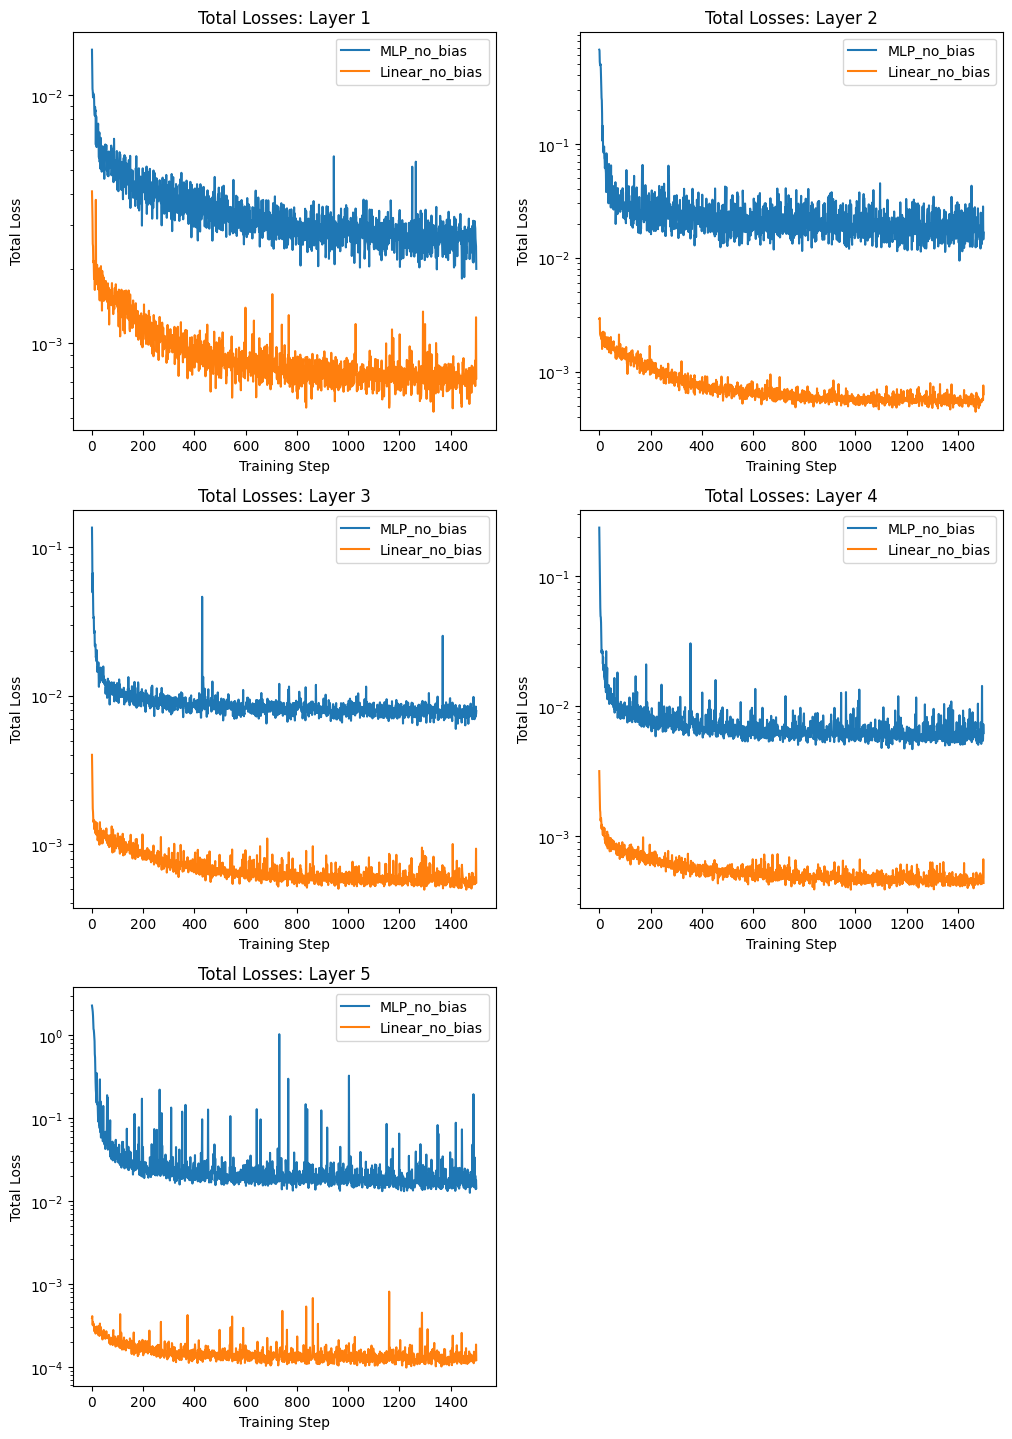

In [51]:
# Plot training curve for total loss
# Plot both losses
import matplotlib.pyplot as plt

num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"Total Losses: Layer {layer+1}")
    # plt.plot(mlp_losses_no_bias[layer][0][::2])
    # plt.plot(linear_losses_no_bias[layer][0][::2])
    plt.plot(mlp_losses_no_bias_mse[layer][0][::2])
    plt.plot(linear_losses_no_bias_mse[layer][0][::2])
    # plt.plot(mlp_losses_no_bias_l1[layer][0][::2])
    # plt.plot(linear_losses_no_bias_l1[layer][0][::2])
    # if(layer ==2):
    #     # set max y to 0.05
    #     plt.ylim(0, 0.03)
    plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    plt.ylabel("Total Loss")
    # y log
    plt.yscale('log')
plt.show()

In [72]:
# for i in range (100):
#     large_weights = (linear_weights_no_bias[0][0].linear.weight[i] > 0.0005).sum()
#     print(f"Large weights: {large_weights}")
for i in range (100):
    large_weights = (mlp_weights_no_bias[0][0].linear.weight[i] > 0.0004).sum()
    print(f"Large weights: {large_weights}")

Large weights: 19
Large weights: 112
Large weights: 36
Large weights: 6
Large weights: 16
Large weights: 9
Large weights: 12
Large weights: 5
Large weights: 2
Large weights: 6
Large weights: 4
Large weights: 21
Large weights: 6
Large weights: 5
Large weights: 8
Large weights: 106
Large weights: 8
Large weights: 8
Large weights: 9
Large weights: 7
Large weights: 332
Large weights: 6
Large weights: 39
Large weights: 7
Large weights: 55
Large weights: 24
Large weights: 86
Large weights: 35
Large weights: 1
Large weights: 279
Large weights: 8
Large weights: 42
Large weights: 10
Large weights: 328
Large weights: 7
Large weights: 374
Large weights: 9
Large weights: 3
Large weights: 7
Large weights: 10
Large weights: 9
Large weights: 16
Large weights: 5
Large weights: 7
Large weights: 4
Large weights: 19
Large weights: 8
Large weights: 6
Large weights: 5
Large weights: 49
Large weights: 126
Large weights: 8
Large weights: 8
Large weights: 7
Large weights: 5
Large weights: 12
Large weights: 4


In [74]:
# Save the sparse weight models
dir = "sparse_weights"
for layer in range(num_layers):
    torch.save(mlp_weights_no_bias[layer][0], f"{dir}/mlp_weights_no_bias_{layer}.pt")
    torch.save(linear_weights_no_bias[layer][0], f"{dir}/linear_weights_no_bias_{layer}.pt")

In [47]:
linear_losses_no_bias[3][0][-1]

0.5426863431930542

## Sweep batch-size

In [14]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
batch_sizes = 4
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for batch_sizes_ind in range(batch_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [19]:
linear_weights_no_bias[0]

[linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 )]

In [24]:

def train_sparse_model_batch_size(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, batch_size_lists, feature_ind, l1_alpha = 8e-4):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for batch_ind, batch_size in enumerate(batch_size_lists):
                # print(f"len of sparseweights: {len(sparse_weights[cache_name_ind])}")
                # print(f"batch ind: {batch_ind}")
                sparse_weight = sparse_weights[cache_name_ind][batch_ind].to(device)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                # Split the batch (input/output_internal_activations) into batch_size amount of chunks
                batched_input_internal_activations = torch.split(input_internal_activations, batch_size, dim=0)
                batched_output_internal_activations = torch.split(output_internal_activations, batch_size, dim=0)
                for b_ind in range(batch_size):
                    x_hat = sparse_weight(batched_input_internal_activations[b_ind])

                    indexed_x_hat = x_hat
                    indexed_output_internal_activations = batched_output_internal_activations[b_ind].index_select(dim=1, index=alive_and_selected_features)
                    
                    # Divide MSE_loss by normalization factor
                    mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                    l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                    # check if sparse_weight.linear2 exists
                    if hasattr(sparse_weight, "linear2"):
                        l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                        l1_loss /= 2
                    unweighted_loss = mse_loss + l1_loss
                    loss = mse_loss + l1_alpha * l1_loss

                    loss.backward()
                    optimizers[cache_name_ind][batch_ind].step()
                    optimizers[cache_name_ind][batch_ind].zero_grad()
                losses[cache_name_ind][batch_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][batch_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][batch_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > 100:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1
batch_size_lists = [1,2,4,8]
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model_batch_size(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, batch_size_lists, linear_features)
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model_batch_size(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, batch_size_lists, mlp_features)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.01108487043529749 | L1 Loss: 16.406333923339844
Layers: 0 | l1 alpha MSE Loss: 0.0072320373728871346 | L1 Loss: 14.048239707946777
Layers: 0 | l1 alpha MSE Loss: 0.0020126362796872854 | L1 Loss: 12.339141845703125
Layers: 0 | l1 alpha MSE Loss: 0.009344893507659435 | L1 Loss: 11.838696479797363
Layers: 1 | l1 alpha MSE Loss: 0.0035510286688804626 | L1 Loss: 27.70962905883789
Layers: 1 | l1 alpha MSE Loss: 0.0020851348526775837 | L1 Loss: 24.861005783081055
Layers: 1 | l1 alpha MSE Loss: 0.0062055205926299095 | L1 Loss: 19.660966873168945
Layers: 1 | l1 alpha MSE Loss: 0.004365518223494291 | L1 Loss: 11.681697845458984
Layers: 2 | l1 alpha MSE Loss: 0.13593453168869019 | L1 Loss: 27.70911979675293
Layers: 2 | l1 alpha MSE Loss: 0.0008077995735220611 | L1 Loss: 24.885446548461914
Layers: 2 | l1 alpha MSE Loss: 0.003832042682915926 | L1 Loss: 19.810791015625
Layers: 2 | l1 alpha MSE Loss: 0.002782099414616823 | L1 Loss: 11.939117431640625
Layers: 3 | l1 al

  0%|          | 1/10963 [00:00<1:37:14,  1.88it/s]

Layers: 4 | l1 alpha MSE Loss: 0.00012494964175857604 | L1 Loss: 19.63352394104004
Layers: 4 | l1 alpha MSE Loss: 0.00017453737382311374 | L1 Loss: 11.440549850463867


  1%|          | 100/10963 [00:41<1:19:26,  2.28it/s]

Layers: 0 | l1 alpha MSE Loss: 0.01148004736751318 | L1 Loss: 10.907217025756836
Layers: 0 | l1 alpha MSE Loss: 0.0001482250081608072 | L1 Loss: 10.433944702148438
Layers: 0 | l1 alpha MSE Loss: 0.0012853475054726005 | L1 Loss: 9.779388427734375
Layers: 0 | l1 alpha MSE Loss: 0.0033413521014153957 | L1 Loss: 8.776857376098633
Layers: 1 | l1 alpha MSE Loss: 0.000371765490854159 | L1 Loss: 0.9866786599159241
Layers: 1 | l1 alpha MSE Loss: 0.0012366654118523002 | L1 Loss: 0.6081542372703552
Layers: 1 | l1 alpha MSE Loss: 0.0004279441200196743 | L1 Loss: 0.5737454891204834
Layers: 1 | l1 alpha MSE Loss: 0.0023512302432209253 | L1 Loss: 0.5838077664375305
Layers: 2 | l1 alpha MSE Loss: 0.004182395990937948 | L1 Loss: 1.3501023054122925
Layers: 2 | l1 alpha MSE Loss: 0.0013818911975249648 | L1 Loss: 0.6858962774276733
Layers: 2 | l1 alpha MSE Loss: 0.0009942067554220557 | L1 Loss: 0.6465616822242737
Layers: 2 | l1 alpha MSE Loss: 0.0009721997193992138 | L1 Loss: 0.6518599987030029
Layers: 3 

  1%|          | 101/10963 [00:42<1:15:14,  2.41it/s]

Layers: 3 | l1 alpha MSE Loss: 0.0006381093407981098 | L1 Loss: 0.49096494913101196
Layers: 3 | l1 alpha MSE Loss: 0.0010913248406723142 | L1 Loss: 0.4924597144126892
Layers: 4 | l1 alpha MSE Loss: 0.013101235963404179 | L1 Loss: 0.4127342700958252
Layers: 4 | l1 alpha MSE Loss: 0.00029025247204117477 | L1 Loss: 0.38380274176597595
Layers: 4 | l1 alpha MSE Loss: 0.0003766260633710772 | L1 Loss: 0.3801612854003906
Layers: 4 | l1 alpha MSE Loss: 0.00013140718510840088 | L1 Loss: 0.3779260516166687


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.16319960355758667 | L1 Loss: 27.716306686401367
Layers: 0 | l1 alpha MSE Loss: 0.01577700302004814 | L1 Loss: 25.64874267578125
Layers: 0 | l1 alpha MSE Loss: 0.0018990858225151896 | L1 Loss: 22.068191528320312
Layers: 0 | l1 alpha MSE Loss: 0.009333942085504532 | L1 Loss: 15.491870880126953
Layers: 1 | l1 alpha MSE Loss: 33.485992431640625 | L1 Loss: 27.69315528869629
Layers: 1 | l1 alpha MSE Loss: 0.020819811150431633 | L1 Loss: 25.687313079833984
Layers: 1 | l1 alpha MSE Loss: 0.04993215203285217 | L1 Loss: 22.296546936035156
Layers: 1 | l1 alpha MSE Loss: 0.05541082099080086 | L1 Loss: 17.264114379882812
Layers: 2 | l1 alpha MSE Loss: 2.2771458625793457 | L1 Loss: 27.662487030029297
Layers: 2 | l1 alpha MSE Loss: 0.04349406063556671 | L1 Loss: 25.71468734741211
Layers: 2 | l1 alpha MSE Loss: 0.05708504095673561 | L1 Loss: 22.483768463134766
Layers: 2 | l1 alpha MSE Loss: 0.05565192177891731 | L1 Loss: 17.82221221923828
Layers: 3 | l1 alpha MSE Loss:

  0%|          | 1/10963 [00:01<3:46:29,  1.24s/it]

Layers: 4 | l1 alpha MSE Loss: 1.7191894054412842 | L1 Loss: 14.76616096496582


  1%|          | 100/10963 [02:01<4:08:57,  1.38s/it]

Layers: 0 | l1 alpha MSE Loss: 0.018970543518662453 | L1 Loss: 5.650140762329102
Layers: 0 | l1 alpha MSE Loss: 0.004428334999829531 | L1 Loss: 4.917581081390381
Layers: 0 | l1 alpha MSE Loss: 0.0451621413230896 | L1 Loss: 4.817112922668457
Layers: 0 | l1 alpha MSE Loss: 0.0006021808367222548 | L1 Loss: 4.370416641235352
Layers: 1 | l1 alpha MSE Loss: 0.0664447620511055 | L1 Loss: 11.791213035583496
Layers: 1 | l1 alpha MSE Loss: 0.27335211634635925 | L1 Loss: 15.092637062072754
Layers: 1 | l1 alpha MSE Loss: 1.1110835075378418 | L1 Loss: 17.98584747314453
Layers: 1 | l1 alpha MSE Loss: 0.01055885013192892 | L1 Loss: 18.779285430908203
Layers: 2 | l1 alpha MSE Loss: 0.02451123669743538 | L1 Loss: 7.997378826141357
Layers: 2 | l1 alpha MSE Loss: 0.014653343707323074 | L1 Loss: 8.486013412475586
Layers: 2 | l1 alpha MSE Loss: 0.04060237854719162 | L1 Loss: 10.007165908813477
Layers: 2 | l1 alpha MSE Loss: 0.007704219780862331 | L1 Loss: 9.779840469360352
Layers: 3 | l1 alpha MSE Loss: 0.

  1%|          | 101/10963 [02:02<4:17:13,  1.42s/it]

Layers: 4 | l1 alpha MSE Loss: 1.088895559310913 | L1 Loss: 18.488967895507812


  1%|          | 101/10963 [02:04<3:42:20,  1.23s/it]


## Sweep over MLP

In [16]:
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, hidden_layer_size=None):
        super().__init__()
        if hidden_layer_size is None:
            hidden_layer_size = input_size
        self.linear = nn.Linear(input_size, hidden_layer_size, bias=False)
        self.linear2 = nn.Linear(hidden_layer_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

mlp_weights_no_bias = []

mlp_optimizers_no_bias = []
hidden_layer_sizes = 13
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    for hidd_layer_s in range(hidden_layer_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, 2**(hidd_layer_s+1)))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [17]:
def train_sparse_model_hidden_unit(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    batch_size = 32
    hidden_unit_models = len(sparse_weights[0])
    losses = [[[] for _ in range(hidden_unit_models)] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for hidden_unit_m in range(hidden_unit_models):
                sparse_weight = sparse_weights[cache_name_ind][hidden_unit_m].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                loss = mse_loss

                loss.backward()
                optimizers[cache_name_ind][hidden_unit_m].step()
                optimizers[cache_name_ind][hidden_unit_m].zero_grad()
                losses[cache_name_ind][hidden_unit_m].append(loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 300 == 0:
                    print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, current_alive_features_ind, mse_loss
                torch.cuda.empty_cache()

        if i > 300:
            # Stop training after 1000 batches
            break
    return losses
mlp_losses_no_bias = train_sparse_model_hidden_unit(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.005501554347574711
Layers: 0 | MSE Loss: 0.00553678534924984
Layers: 0 | MSE Loss: 0.005442761350423098
Layers: 0 | MSE Loss: 0.005443949718028307
Layers: 0 | MSE Loss: 0.0054717641323804855
Layers: 0 | MSE Loss: 0.00543338805437088
Layers: 0 | MSE Loss: 0.005409144330769777
Layers: 0 | MSE Loss: 0.005405251402407885
Layers: 0 | MSE Loss: 0.005431877449154854
Layers: 0 | MSE Loss: 0.005403609946370125
Layers: 0 | MSE Loss: 0.0054214466363191605
Layers: 0 | MSE Loss: 0.005428903270512819
Layers: 0 | MSE Loss: 0.005418367218226194
Layers: 1 | MSE Loss: 0.06880893558263779
Layers: 1 | MSE Loss: 0.06885495781898499
Layers: 1 | MSE Loss: 0.06853997707366943
Layers: 1 | MSE Loss: 0.06845316290855408
Layers: 1 | MSE Loss: 0.06851335614919662
Layers: 1 | MSE Loss: 0.0686269998550415
Layers: 1 | MSE Loss: 0.06857927143573761
Layers: 1 | MSE Loss: 0.0686480700969696
Layers: 1 | MSE Loss: 0.06843666732311249
Layers: 1 | MSE Loss: 0.06871131807565689
Layers: 1 | MSE Loss: 0

  0%|          | 1/10963 [00:02<8:23:12,  2.75s/it]

Layers: 4 | MSE Loss: 4.555083751678467


  3%|▎         | 300/10963 [13:46<8:11:05,  2.76s/it] 

Layers: 0 | MSE Loss: 0.004248362500220537
Layers: 0 | MSE Loss: 0.004250658210366964
Layers: 0 | MSE Loss: 0.0042420318350195885
Layers: 0 | MSE Loss: 0.00382217182777822
Layers: 0 | MSE Loss: 0.0032627990003675222
Layers: 0 | MSE Loss: 0.002748209750279784
Layers: 0 | MSE Loss: 0.002356917131692171
Layers: 0 | MSE Loss: 0.0019626086577773094
Layers: 0 | MSE Loss: 0.0015897859120741487
Layers: 0 | MSE Loss: 0.00132092391140759
Layers: 0 | MSE Loss: 0.001136928447522223
Layers: 0 | MSE Loss: 0.0010089885909110308
Layers: 0 | MSE Loss: 0.001014913315884769
Layers: 1 | MSE Loss: 0.05118892341852188
Layers: 1 | MSE Loss: 0.049422748386859894
Layers: 1 | MSE Loss: 0.01966453343629837
Layers: 1 | MSE Loss: 0.01270791795104742
Layers: 1 | MSE Loss: 0.009349728003144264
Layers: 1 | MSE Loss: 0.008106575347483158
Layers: 1 | MSE Loss: 0.006919429171830416
Layers: 1 | MSE Loss: 0.005623080767691135
Layers: 1 | MSE Loss: 0.004562114365398884
Layers: 1 | MSE Loss: 0.003838918637484312
Layers: 1 |

  3%|▎         | 301/10963 [13:49<8:10:50,  2.76s/it]

Layers: 4 | MSE Loss: 0.06059036776423454


  3%|▎         | 301/10963 [13:52<8:11:25,  2.77s/it]


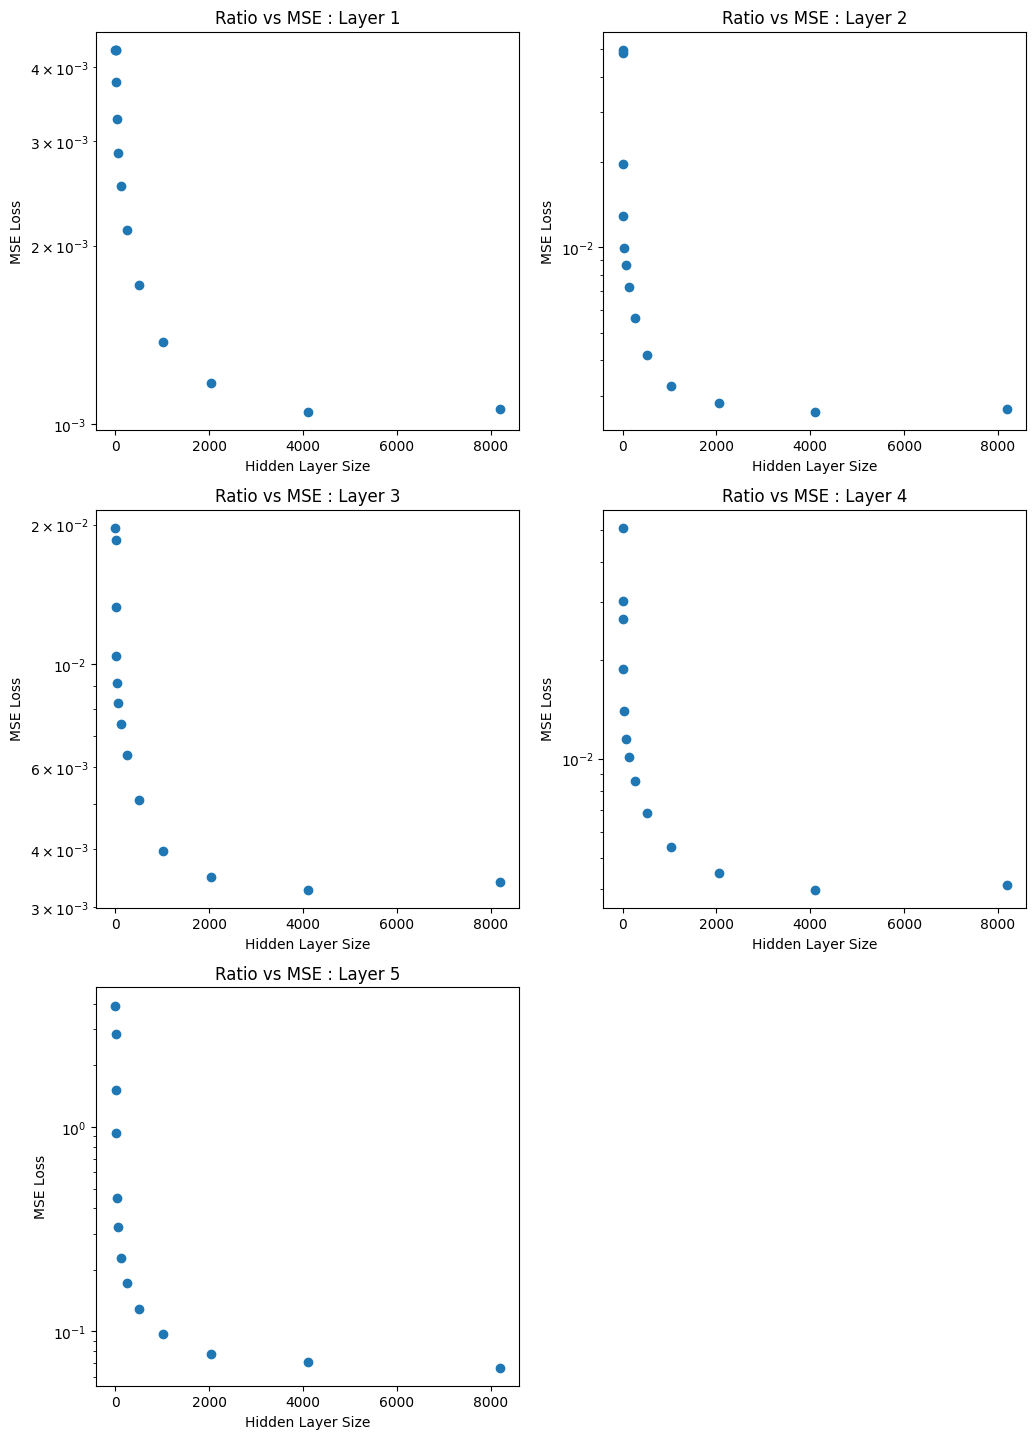

In [20]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

hidden_layer_sizes
mlp_losses_last = np.zeros((num_layers, hidden_layer_sizes))
for layer in range(num_layers):
    for hidden_layer_s in range(hidden_layer_sizes):
        mlp_losses_last[layer, hidden_layer_s] = mlp_losses_no_bias[layer][hidden_layer_s][-1]

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed
ratios = [2**(i+1) for i in range(hidden_layer_sizes)]
for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"Ratio vs MSE : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_losses_last[layer]
    # Plot
    plt.plot(ratios, mlp_l1_loss, 'o')
    plt.yscale('log')
    # plt.xscale('log')
    # plt.legend()
    plt.ylabel("MSE Loss")
    plt.xlabel("Hidden Layer Size")
plt.show()

In [13]:
ratios

[2, 4, 8, 16, 32, 64, 128, 256]

In [31]:
len(mlp_losses_no_bias[0][0])

5

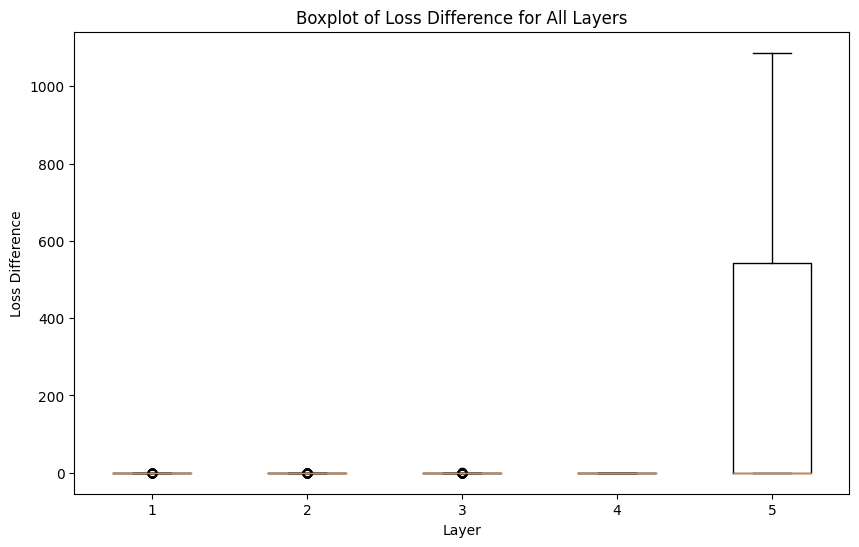

In [19]:
import matplotlib.pyplot as plt

# Collect all loss_diff data for each layer into a list
all_layers_loss_diff = [loss_diff[layer] for layer in range(len(loss_diff))]

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(all_layers_loss_diff)
plt.title("Boxplot of Loss Difference for All Layers")
plt.xlabel("Layer")
plt.ylabel("Loss Difference")

plt.show()

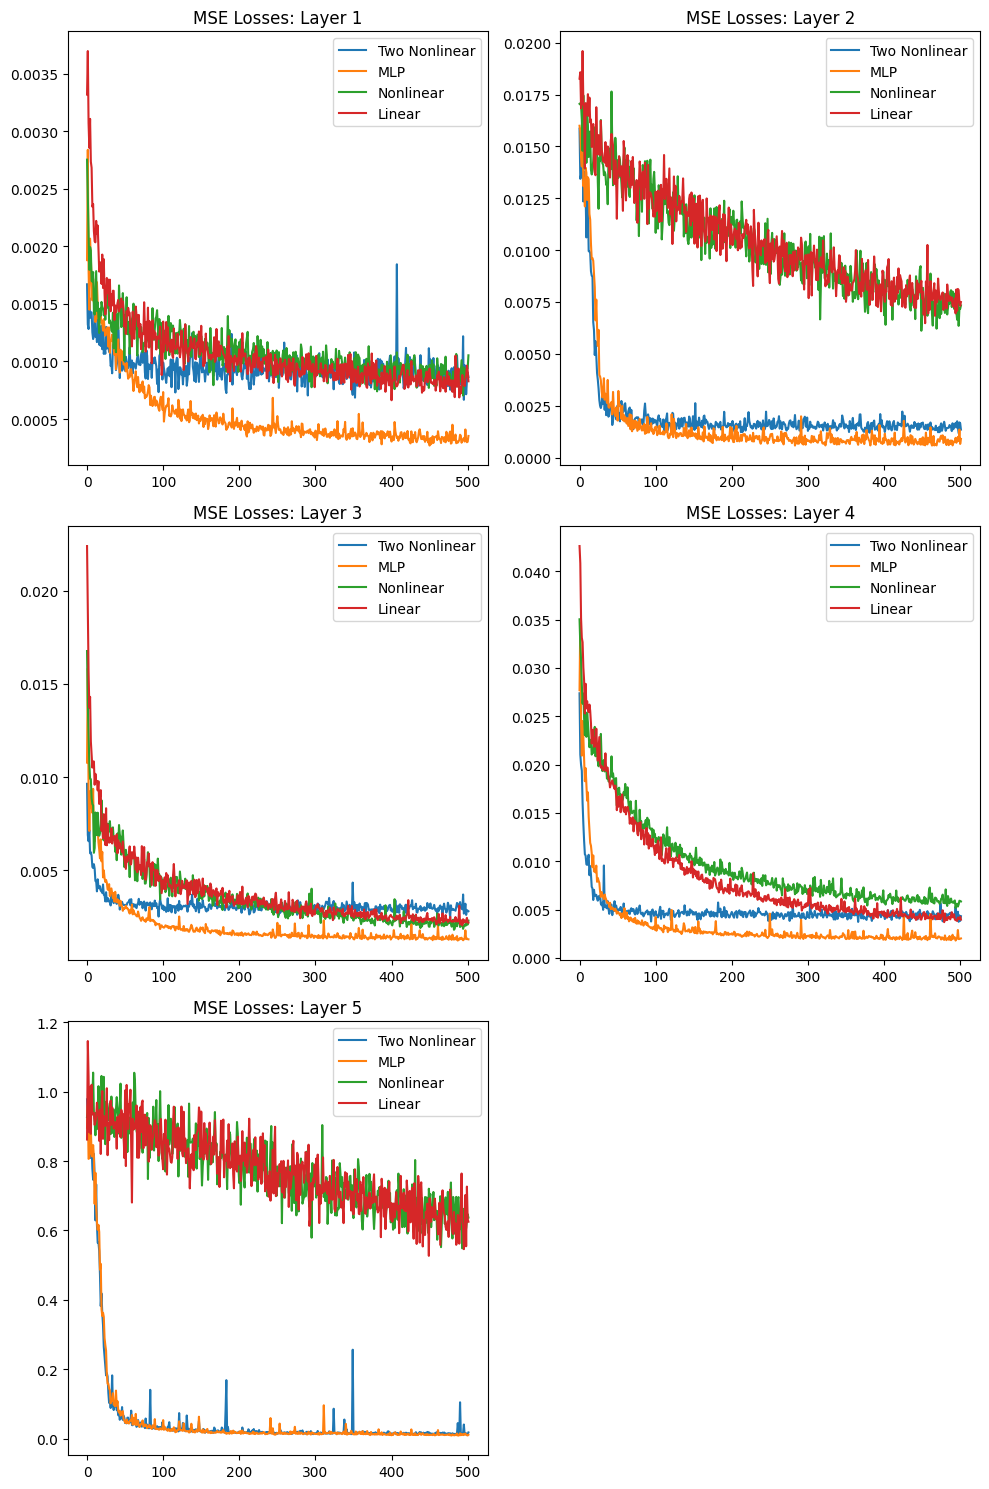

In [15]:
import matplotlib.pyplot as plt

num_layers = len(two_nonlinear_losses)
num_columns = 2  # You can adjust this based on how many plots you want per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer], label="Two Nonlinear")
    plt.plot(mlp_losses[layer], label="MLP")
    plt.plot(nonlinear_losses[layer], label="Nonlinear")
    plt.plot(linear_losses[layer], label="Linear")
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
nonlinear_losses, linear_loss

(array([0.00114306, 0.02376839, 0.00199088, 0.00503561, 0.70069301]),
 array([0.00112041, 0.02399791, 0.00216295, 0.00460967, 0.70566905]))

In [53]:
from baukit import TraceDict
mse = nn.MSELoss()
l1_alpha = 1e-3
datapoints = dataset.num_rows
batch_size = 32
losses = np.zeros(len(sparse_weights))
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(dl):
        batch = batch.to(device)
        with torch.no_grad():
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        # # Get every 2 cache names (since they're matched up)
        for cache_name_ind in range(len(cache_names)//2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[(cache_name_ind*2)]
            output_cache_name = cache_names[(cache_name_ind*2)+1]
            input_autoencoder = autoencoders[(cache_name_ind*2)]
            output_autoencoder = autoencoders[(cache_name_ind*2)+1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(input_activations, tuple)):
                input_activations = input_activations[0]
            if(isinstance(output_activations, tuple)):
                output_activations = output_activations[0]
            # Rearrange to (batch_size*seq_length, num_features)
            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n" )
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n" )
            # Encode
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            # Encode
            x_hat = sparse_weights[cache_name_ind](input_internal_activations)
            # Get loss
            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha*l1_loss
            # Backprop
            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind] = loss.item()
            if(i%50==0):
                print(f"Layers: {cache_name_ind} |  MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")


Layers: 0 |  MSE Loss: 0.0032902932725846767 | L1 Loss: 27.721176147460938
Layers: 1 |  MSE Loss: 0.045880552381277084 | L1 Loss: 27.712087631225586
Layers: 2 |  MSE Loss: 0.02548954077064991 | L1 Loss: 27.71087646484375
Layers: 3 |  MSE Loss: 0.0651974007487297 | L1 Loss: 27.717008590698242
Layers: 4 |  MSE Loss: 0.8611162900924683 | L1 Loss: 27.709190368652344
Layers: 0 |  MSE Loss: 0.001719774678349495 | L1 Loss: 24.83885955810547
Layers: 1 |  MSE Loss: 0.038391195237636566 | L1 Loss: 26.483190536499023
Layers: 2 |  MSE Loss: 0.0042221806943416595 | L1 Loss: 28.59328269958496
Layers: 3 |  MSE Loss: 0.02699713036417961 | L1 Loss: 28.991947174072266
Layers: 4 |  MSE Loss: 0.8554728031158447 | L1 Loss: 29.95911979675293
Layers: 0 |  MSE Loss: 0.0017383686499670148 | L1 Loss: 24.861730575561523
Layers: 1 |  MSE Loss: 0.035102322697639465 | L1 Loss: 26.954181671142578
Layers: 2 |  MSE Loss: 0.0031695878133177757 | L1 Loss: 29.906362533569336
Layers: 3 |  MSE Loss: 0.018583638593554497 | 

In [55]:
losses_mlp, losses

# See if the top weights have high cosine similarity between the two

In [13]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
# for f_out, f_in in indices:
    # Find the cosine similarity between these two vectors

dict_in = autoencoders[0].get_learned_dict()
dict_out = autoencoders[1].get_learned_dict()


In [1]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [24]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3108, 0.3100, 0.3035, 0.3032, 0.3001, 0.2986, 0.2986, 0.2979, 0.2974,
         0.2940], device='cuda:0'),
 tensor([2390, 2863, 2390, 1224, 2863, 1224, 1582, 2863, 1582, 1582],
        device='cuda:0'),
 tensor([3028, 3028,  247,  247,  887,  887,  887, 1904,  247,   67],
        device='cuda:0'))

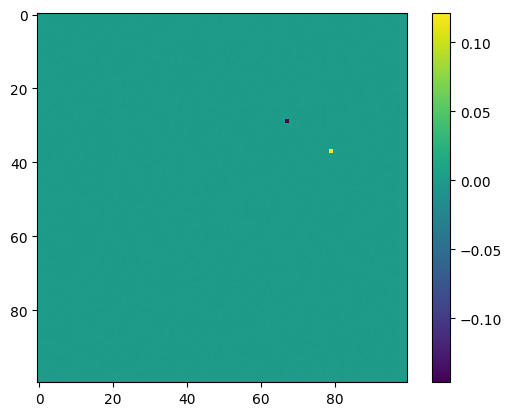

In [25]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [33]:
threshold_pos = 0.1
threshold_neg = -0.1
total_weights = Sparse_nonlinear.linear.weight.numel()
(Sparse_nonlinear.linear.weight > threshold_pos).count_nonzero() / total_weights, (Sparse_nonlinear.linear.weight < threshold_neg).count_nonzero() / total_weights, total_weights

(tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'), 9437184)

In [35]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [  11,  596],
         [  11, 1184],
         ...,
         [3059, 2127],
         [3059, 3066],
         [3065, 2497]], device='cuda:0'),
 tensor([0.1686, 0.1715, 0.1995,  ..., 0.2472, 0.1418, 0.1529], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [38]:
indices[:10]

tensor([[   1, 2191],
        [  11,  596],
        [  11, 1184],
        [  11, 2676],
        [  14, 2468],
        [  19, 1166],
        [  20,  719],
        [  28,  232],
        [  28,  662],
        [  29, 1404]], device='cuda:0')

In [39]:
indices[10:20]

tensor([[  31, 2115],
        [  31, 2399],
        [  31, 3014],
        [  34, 2422],
        [  37,   79],
        [  37, 1885],
        [  89, 1323],
        [ 103,  837],
        [ 103, 2310],
        [ 105, 1565]], device='cuda:0')

In [40]:
indices[20:30]

tensor([[ 105, 2002],
        [ 105, 2697],
        [ 106,   67],
        [ 106,  146],
        [ 106,  189],
        [ 106,  247],
        [ 106,  330],
        [ 106,  344],
        [ 106,  458],
        [ 106,  690]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

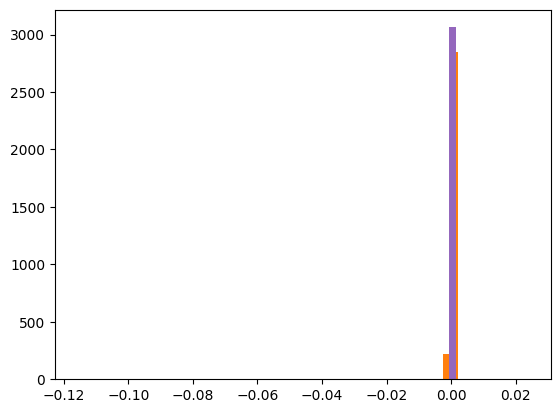

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

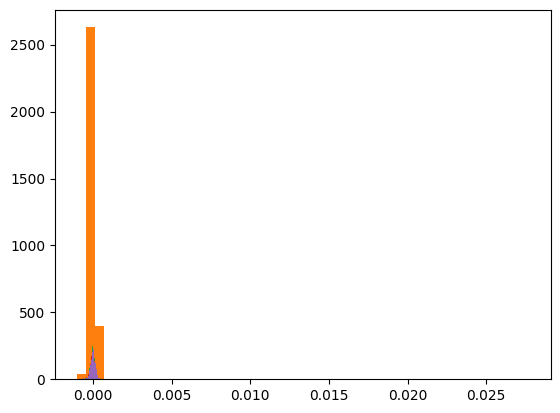

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()